# Feb 25th, 2022 (ovp score, C_i; pie charts)

**Motivation**: How many disjoint nodes?  How many with mixed-membership? <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE

def plot_():
    pass

## Fig dir

In [3]:
fig_dir = pjoin(tmp_dir, 'fig_25th')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [4]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ids

[0, 1, 2, 3, 4]

## Overlap score

In [6]:
thres = 0.15
dlist = []

i, j, k = gr_bold.run_pi_prune.shape[:3]
looper = itertools.product(range(i), range(j), range(k))
for i, j, k in looper:
    x = gr_bold.run_pi_prune[i, j, k]
    nonan = np.isnan(x).sum(0) == 0
    if not nonan.sum():
            continue
    x = bn.nansum(x >= thres, 0) - 1
    ovp = collections.Counter(x)
    ovp = {
        s: c for s, c
        in sorted(ovp.items())
        if s >= 0
    }
    ovp = {
        s: 100 * (c / (sum(ovp.values())))
        for s, c in ovp.items()
    }
    ovp = {
        s + 1: ovp.get(s, 0)
        for s in range(5)
    }
    dlist.append({
        'mode': ['bold-lite'] * len(ovp),
        'key': [mice.get_key(i+1, j+1, k+1)] * len(ovp),
        'subject': [i + 1] * len(ovp),
        'score': ovp.keys(),
        'proportion': ovp.values(),
    })
    
i, j, k = gr_ca.run_pi_prune.shape[:3]
looper = itertools.product(range(i), range(j), range(k))
for i, j, k in looper:
    x = gr_ca.run_pi_prune[i, j, k]
    nonan = np.isnan(x).sum(0) == 0
    if not nonan.sum():
            continue
    x = bn.nansum(x >= thres, 0) - 1
    ovp = collections.Counter(x)
    ovp = {
        s: c for s, c
        in sorted(ovp.items())
        if s >= 0
    }
    ovp = {
        s: 100 * (c / (sum(ovp.values())))
        for s, c in ovp.items()
    }
    ovp = {
        s + 1: ovp.get(s, 0)
        for s in range(5)
    }
    dlist.append({
        'mode': ['ca2'] * len(ovp),
        'key': [mice.get_key(i+1, j+1, k+1)] * len(ovp),
        'subject': [i + 1] * len(ovp),
        'score': ovp.keys(),
        'proportion': ovp.values(),
    })
    
df = pd.DataFrame(merge_dicts(dlist))
df_means = df.groupby(['mode', 'score']).mean().drop(columns=['subject'])

df['tag'] = 'mixed'
df.loc[df['score'] == 1, 'tag'] = 'disjoint'

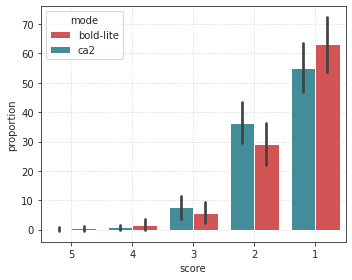

In [12]:
fig, ax = create_figure(figsize=(5, 4))
sns.barplot(
    data=df,
    x='score',
    y='proportion',
    hue='mode',
    palette=pal,
    ci='sd',
    ax=ax,
)
ax.invert_xaxis()
ax.grid()

In [13]:
n_resamples = int(2e4)
dims = {'sub': 10, 'ses': 3, 'run': 4}
booted_bold = bootstrap(
    x=gr_bold.run_pi_prune,
    n_resamples=n_resamples,
    batch=5,
    dims=dims,
    est=None,
)
booted_ca = bootstrap(
    x=gr_ca.run_pi_prune,
    n_resamples=n_resamples,
    batch=5,
    dims=dims,
    est=None,
)

In [14]:
boot_values_bold = np.zeros((n_resamples, 5))
boot_values_ca = np.zeros((n_resamples, 5))
for b in tqdm(range(n_resamples)):
    data_bold = np.zeros((10, 3, 4, 5))
    data_ca = np.zeros((10, 3, 4, 5))
    looper = itertools.product(range(10), range(3), range(4))
    for i, j, k in looper:
        x = booted_bold[b, i, j, k]
        nonan = np.isnan(x).sum(0) == 0
        if not nonan.sum():
                continue
        x = bn.nansum(x >= thres, 0) - 1
        ovp = collections.Counter(x)
        ovp = {
            s: c for s, c
            in sorted(ovp.items())
            if s >= 0
        }
        ovp = {
            s: 100 * (c / (sum(ovp.values())))
            for s, c in ovp.items()
        }
        ovp = {
            s + 1: ovp.get(s, 0)
            for s in range(5)
        }
        data_bold[i, j, k, :] = list(ovp.values())
        
        x = booted_ca[b, i, j, k]
        nonan = np.isnan(x).sum(0) == 0
        if not nonan.sum():
                continue
        x = bn.nansum(x >= thres, 0) - 1
        ovp = collections.Counter(x)
        ovp = {
            s: c for s, c
            in sorted(ovp.items())
            if s >= 0
        }
        ovp = {
            s: 100 * (c / (sum(ovp.values())))
            for s, c in ovp.items()
        }
        ovp = {
            s + 1: ovp.get(s, 0)
            for s in range(5)
        }
        data_ca[i, j, k, :] = list(ovp.values())
        
    boot_values_bold[b] = data_bold.mean(2).mean(1).mean(0)
    boot_values_ca[b] = data_ca.mean(2).mean(1).mean(0)
boot_values_bold.shape, boot_values_ca.shape

  0%|          | 0/20000 [00:00<?, ?it/s]

((20000, 5), (20000, 5))

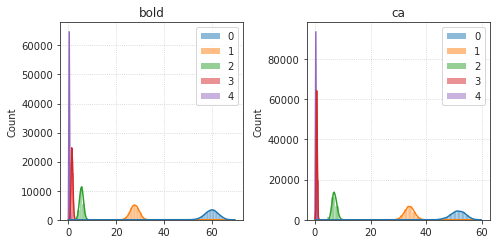

In [15]:
fig, axes = create_figure(1, 2, (7, 3.5))
sns.histplot(boot_values_bold, kde=True, ax=axes[0])
sns.histplot(boot_values_ca, kde=True, ax=axes[1])
axes[0].set_title('bold')
axes[1].set_title('ca')
add_grid(axes)
plt.show()

In [16]:
se_boot_bold = bn.nanstd(boot_values_bold, 0, ddof=1)
se_boot_ca = bn.nanstd(boot_values_ca, 0, ddof=1)

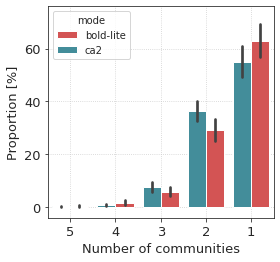

In [17]:
fig, ax = create_figure(figsize=(4, 3.75))
sns.barplot(
    data=df,
    x='score',
    y='proportion',
    hue='mode',
    palette=pal,
    ci='sd',
    ax=ax,
)
ci = 0.95
whis = np.round((1 + ci) / 2, 5)
dof = 9
t = sp_stats.t.ppf(whis, dof)

lines = ax.get_lines()
for i in range(5):
    mu = df_means.loc['bold-lite'].values.ravel()[i]
    a = mu - t * se_boot_bold[i]
    b = mu + t * se_boot_bold[i]
    lines[i].set_ydata([a, b])
    
    mu = df_means.loc['ca2'].values.ravel()[i]
    a = mu - t * se_boot_ca[i]
    b = mu + t * se_boot_ca[i]
    lines[i + 5].set_ydata([a, b])

ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Number of communities', fontsize=13)
ax.set_ylabel('Proportion [%]', fontsize=13)
ax.invert_xaxis()
ax.grid()

name = f'overlap-score_thres{thres:.2f}'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')
plt.show()

In [18]:
disjoint_bold = df_means.loc['bold-lite'].values.ravel()[0]
disjoint_ca = df_means.loc['ca2'].values.ravel()[0]

disjoint_bold, disjoint_ca

(63.05236431030389, 55.08271297442858)

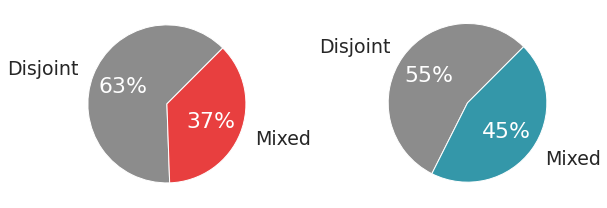

In [24]:
grey = list(sns.color_palette('deep'))[-3]
# fig, axes = create_figure(1, 2, (8.5, 4.0 if thres == 0.2 else 5))
fig, axes = create_figure(1, 2, (8.5, 3.0))

*_, autotexts = axes[0].pie(
    x=[disjoint_bold, 100 - disjoint_bold],
    labels=['Disjoint', 'Mixed'],
    explode=(0, 0),
    autopct='%1.0f%%',
    shadow=False,
    startangle=30 if thres == 0.2 else 45,
    labeldistance=1.2,
    colors=[grey, pal['bold-lite']],
    textprops={'fontsize': 19},
)
_ = [t.set_fontsize(22) for t in autotexts]
_ = [t.set_color('white') for t in autotexts]
# axes[0].set_title('Bold', fontsize=22)
axes[0].axis('equal')

*_, autotexts = axes[1].pie(
    x=[disjoint_ca, 100 - disjoint_ca],
    labels=['Disjoint', 'Mixed'],
    explode=(0, 0),
    autopct='%1.0f%%',
    shadow=False,
    startangle=30 if thres == 0.2 else 45,
    labeldistance=1.2,
    colors=[grey, pal['ca2']],
    textprops={'fontsize': 19},
)
_ = [t.set_fontsize(22) for t in autotexts]
_ = [t.set_color('white') for t in autotexts]
# axes[1].set_title(r'Ca$^{2+}$', fontsize=22)
axes[1].axis('equal')

name = f'pie_thres{thres:.2f}'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')
plt.show()

## New bins?

In [88]:
np.linspace(0.2, 1, 17)

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

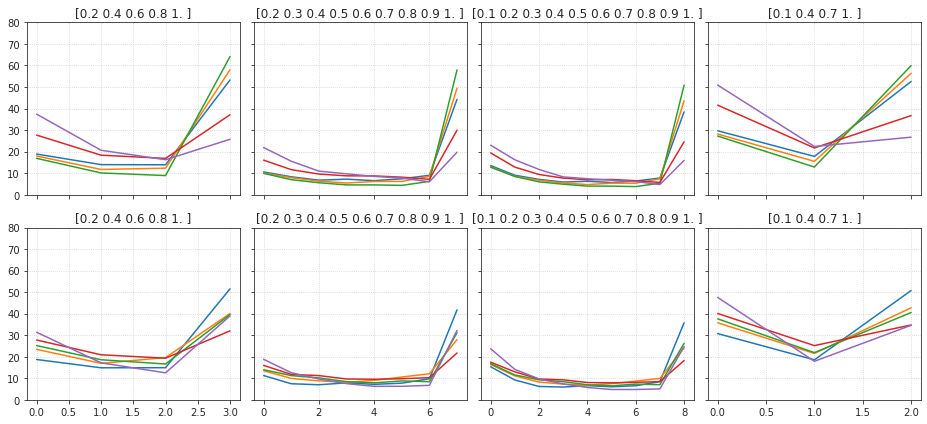

In [90]:
bins = [np.linspace(0.2, 1.0, 5), np.linspace(0.2, 1.0, 9), np.linspace(0.1, 1.0, 10), np.linspace(0.1, 1.0, 4)]

fig, axes = create_figure(2, 4, (13, 6), 'col', 'all')
for i, b in enumerate(bins):
    statistic = mk_statistic_fn(b, scipy=False)
    output = statistic(gr_ca.run_pi_prune)
    ax = axes[1, i]
    ax.set_title(b)
    ax.plot(output['cut_avg'].T)
    ax.set_ylim(0, 60)
    
    statistic = mk_statistic_fn(b, scipy=False)
    output = statistic(gr_bold.run_pi_prune)
    ax = axes[0, i]
    ax.set_title(b)
    ax.plot(output['cut_avg'].T)
    ax.set_ylim(0, 80)

add_grid(axes)
plt.show()

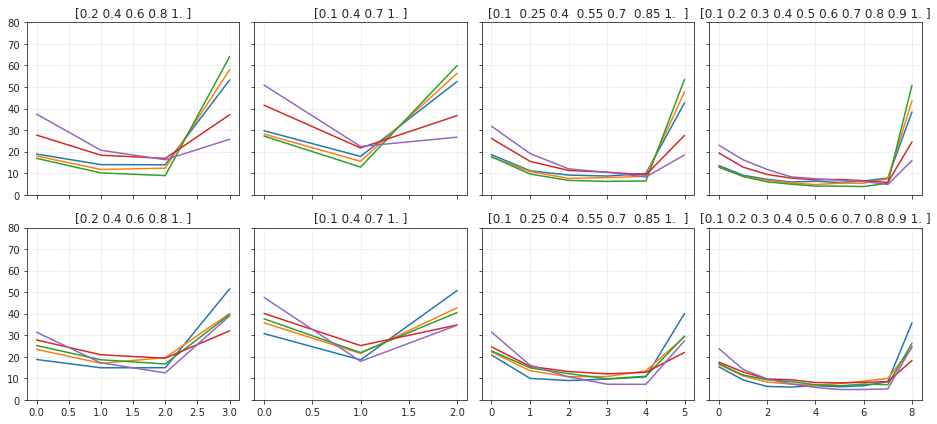

In [95]:
bins = [np.linspace(0.2, 1.0, 5), np.linspace(0.1, 1.0, 4), np.linspace(0.1, 1.0, 7), np.linspace(0.1, 1.0, 10)]

fig, axes = create_figure(2, 4, (13, 6), 'col', 'all')
for i, b in enumerate(bins):
    statistic = mk_statistic_fn(b, scipy=False)
    output = statistic(gr_ca.run_pi_prune)
    ax = axes[1, i]
    ax.set_title(b)
    ax.plot(output['cut_avg'].T)
    ax.set_ylim(0, 60)
    
    statistic = mk_statistic_fn(b, scipy=False)
    output = statistic(gr_bold.run_pi_prune)
    ax = axes[0, i]
    ax.set_title(b)
    ax.plot(output['cut_avg'].T)
    ax.set_ylim(0, 80)

add_grid(axes)
plt.show()

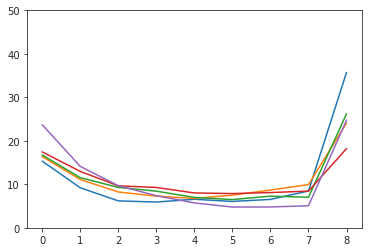

In [62]:
plt.plot(output['cut_avg'].T)
plt.ylim(0, 50);

In [113]:
bins = np.linspace(0.05, 1., 20)
bins

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

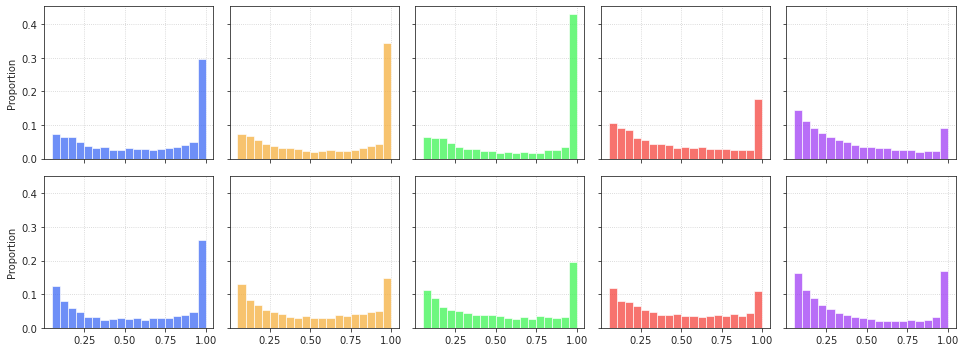

In [114]:
bins = bins = np.linspace(0.05, 1., 20)

fig, axes = create_figure(2, 5, (13.5, 5), 'all', 'all')
for i in range(5):
    x = gr_bold.run_pi_prune[..., i, :]
    x = x[np.isfinite(x)]
    x = x[x > 0.05]
    ax = axes[0, i]
    sns.histplot(x, color=gr_bold.colors[i + 1], bins=bins, stat='proportion', ax=ax)

    x = gr_ca.run_pi_prune[..., i, :]
    x = x[np.isfinite(x)]
    x = x[x > 0.05]
    ax = axes[1, i]
    sns.histplot(x, color=gr_bold.colors[i + 1],  bins=bins, stat='proportion', ax=ax)
    
add_grid(axes)
plt.show()

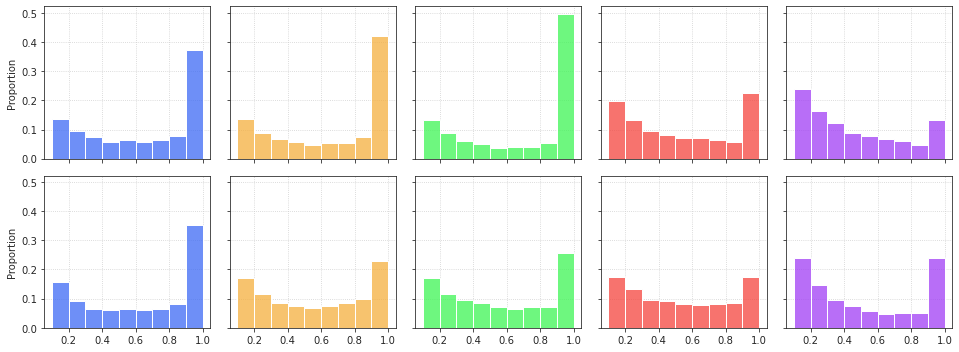

In [122]:
bins = bins = np.linspace(0.1, 1., 10)

fig, axes = create_figure(2, 5, (13.5, 5), 'all', 'all')
for i in range(5):
    x = gr_bold.run_pi_prune[..., i, :]
    x = x[np.isfinite(x)]
    x = x[x > 0.05]
    ax = axes[0, i]
    sns.histplot(x, color=gr_bold.colors[i + 1], bins=bins, stat='proportion', ax=ax)

    x = gr_ca.run_pi_prune[..., i, :]
    x = x[np.isfinite(x)]
    x = x[x > 0.05]
    ax = axes[1, i]
    sns.histplot(x, color=gr_bold.colors[i + 1],  bins=bins, stat='proportion', ax=ax)
    
add_grid(axes)
plt.show()

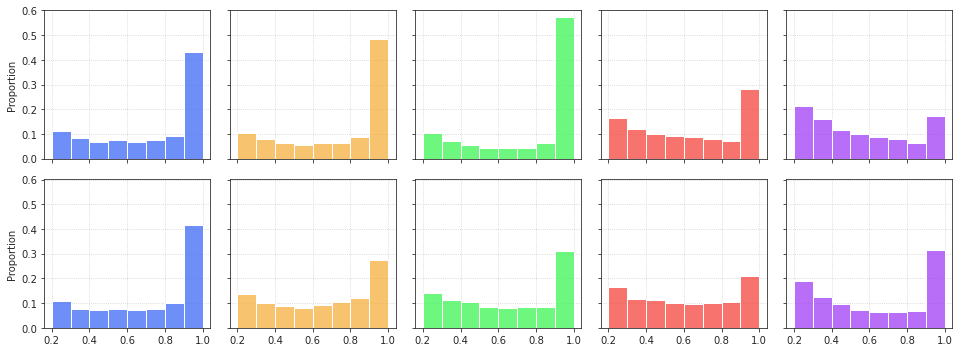

In [123]:
bins = bins = np.linspace(0.2, 1., 9)

fig, axes = create_figure(2, 5, (13.5, 5), 'all', 'all')
for i in range(5):
    x = gr_bold.run_pi_prune[..., i, :]
    x = x[np.isfinite(x)]
    x = x[x > 0.05]
    ax = axes[0, i]
    sns.histplot(x, color=gr_bold.colors[i + 1], bins=bins, stat='proportion', ax=ax)

    x = gr_ca.run_pi_prune[..., i, :]
    x = x[np.isfinite(x)]
    x = x[x > 0.05]
    ax = axes[1, i]
    sns.histplot(x, color=gr_bold.colors[i + 1],  bins=bins, stat='proportion', ax=ax)
    
add_grid(axes)
plt.show()